In [51]:
# Cell 1: Import required libraries
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image


In [52]:
# Cell 2: Load dataset from directory
BATCH_SIZE = 32
IMAGE_SIZE = 256  # Resize the images to 256x256 for simplicity
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",  # Path to the PlantVillage dataset directory
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 3 classes.


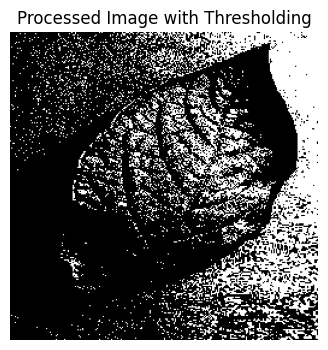

In [53]:
# Cell 3: Preprocess image (convert to grayscale and apply thresholding)
def preprocess_image(image):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply thresholding to detect spots
    _, thresholded_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)
    
    return thresholded_image

# Sample image from the dataset
for images, labels in dataset.take(1):
    sample_image = images[0].numpy().astype(np.uint8)  # Convert to numpy array
    processed_image = preprocess_image(sample_image)
    
    # Show the thresholded image
    plt.figure(figsize=(4, 4))
    plt.imshow(processed_image, cmap='gray')
    plt.title("Processed Image with Thresholding")
    plt.axis('off')
    plt.show()


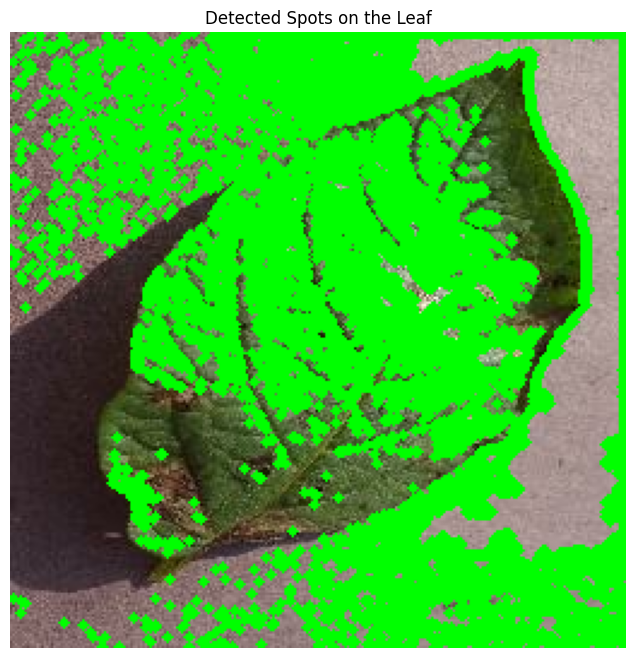

Number of detected spots: 1430


In [54]:
# Cell 4: Detect contours (spots) on the leaf
def detect_spots(image):
    # Find contours of the spots in the thresholded image
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Draw contours on the original image
    image_with_spots = cv2.drawContours(sample_image.copy(), contours, -1, (0, 255, 0), 3)
    
    return image_with_spots, contours

# Detect spots and visualize the result
image_with_spots, contours = detect_spots(processed_image)

# Display the image with detected spots
plt.figure(figsize=(8, 8))
plt.imshow(image_with_spots)
plt.title("Detected Spots on the Leaf")
plt.axis('off')
plt.show()

# Print the number of detected spots (contours)
print(f"Number of detected spots: {len(contours)}")


In [55]:
# Cell 5: Analyze the properties of the detected spots
def analyze_spots(contours):
    spot_properties = []
    
    for contour in contours:
        # Calculate area and perimeter of each spot
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        
        # Get bounding box for each spot
        x, y, w, h = cv2.boundingRect(contour)
        
        spot_properties.append({
            "area": area,
            "perimeter": perimeter,
            "bounding_box": (x, y, w, h)
        })
    
    return spot_properties

# Analyze the properties of the detected spots
spot_properties = analyze_spots(contours)

# Print some of the spot properties
for i, props in enumerate(spot_properties[:5]):  # Display the first 5 spots
    print(f"Spot {i+1}:")
    print(f"  Area: {props['area']}")
    print(f"  Perimeter: {props['perimeter']}")
    print(f"  Bounding Box: {props['bounding_box']}")


Spot 1:
  Area: 0.0
  Perimeter: 0.0
  Bounding Box: (216, 255, 1, 1)
Spot 2:
  Area: 0.0
  Perimeter: 2.0
  Bounding Box: (201, 255, 2, 1)
Spot 3:
  Area: 0.0
  Perimeter: 2.0
  Bounding Box: (176, 255, 2, 1)
Spot 4:
  Area: 0.0
  Perimeter: 0.0
  Bounding Box: (161, 255, 1, 1)
Spot 5:
  Area: 0.0
  Perimeter: 2.0
  Bounding Box: (153, 255, 2, 1)


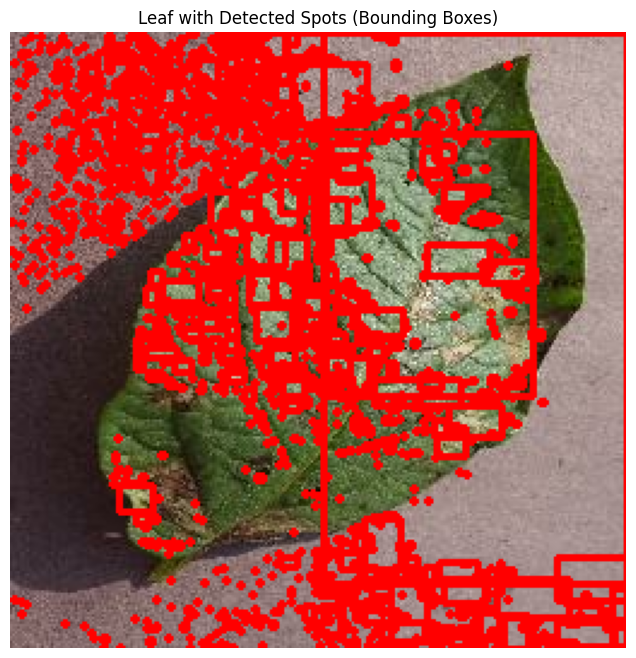

In [56]:
# Cell 6: Summarize the spot detection and visualization
def summarize_spots(image, spot_properties):
    # Show the original image with bounding boxes around the spots
    image_with_bounding_boxes = image.copy()
    
    for props in spot_properties:
        x, y, w, h = props["bounding_box"]
        cv2.rectangle(image_with_bounding_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    # Display the image with bounding boxes
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_bounding_boxes)
    plt.title("Leaf with Detected Spots (Bounding Boxes)")
    plt.axis('off')
    plt.show()

# Summarize and display the results
summarize_spots(sample_image, spot_properties)


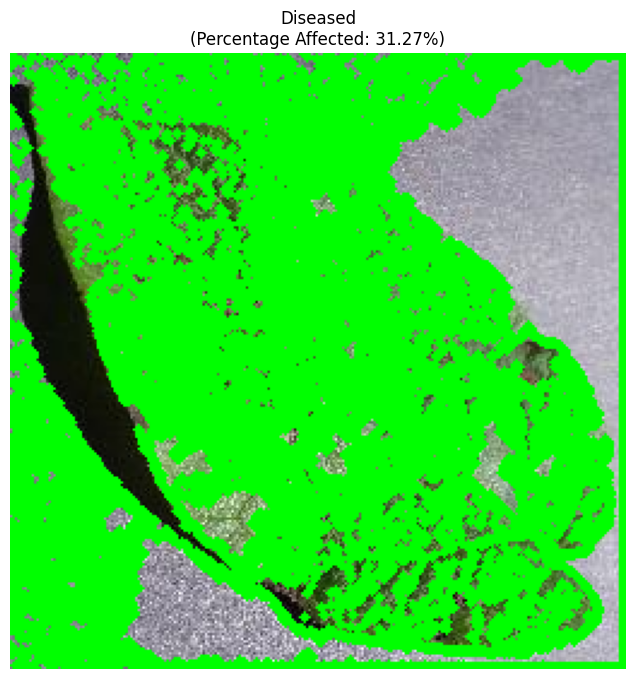

Percentage of the leaf affected by disease spots: 31.27%
Classification: Diseased


In [57]:
# Cell 4 (Updated): Detect spots, calculate the percentage, and classify as diseased or not diseased
def detect_and_classify_disease(image, threshold=5):
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply thresholding to detect spots
    _, thresholded_image = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)
    
    # Find contours of the spots in the thresholded image
    contours, _ = cv2.findContours(thresholded_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Calculate the total leaf area (in pixels)
    total_leaf_area = image.shape[0] * image.shape[1]  # Height * Width of the image
    
    # Calculate the total area of the detected spots
    total_spot_area = sum([cv2.contourArea(contour) for contour in contours])
    
    # Calculate the percentage affected by disease spots
    percentage_affected = (total_spot_area / total_leaf_area) * 100
    
    # Classify as diseased or not diseased based on the threshold
    if percentage_affected > threshold:
        classification = "Diseased"
    else:
        classification = "Not Diseased"
    
    # Draw the contours on the image
    image_with_spots = cv2.drawContours(image.copy(), contours, -1, (0, 255, 0), 3)
    
    return image_with_spots, percentage_affected, classification

# Example usage with a sample image from the dataset
for images, labels in dataset.take(1):
    sample_image = images[0].numpy().astype(np.uint8)  # Convert to numpy array
    image_with_spots, percentage_affected, classification = detect_and_classify_disease(sample_image)
    
    # Show the image with detected spots
    plt.figure(figsize=(8, 8))
    plt.imshow(image_with_spots)
    plt.title(f"{classification}\n(Percentage Affected: {percentage_affected:.2f}%)")
    plt.axis('off')
    plt.show()
    
    # Print the result
    print(f"Percentage of the leaf affected by disease spots: {percentage_affected:.2f}%")
    print(f"Classification: {classification}")
